<a href="https://colab.research.google.com/github/barghavanii/AI-for-Cybersecurity/blob/main/FGSM_Attack_Nov2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast Gradient Sign Method (FGSM) Attack

#### This guide explores the FGSM attack which was first described by I. Goodfellow et al.* and is implemented with Tensorflow 2.0.
>
*[Explaining and Harnessing Adversarial Examples](https://arxiv.org/pdf/1412.6572.pdf)


## Import dependent libraries
Tensorflow 2.7.x


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2.15.0
GPU Available:  True


## Training a simple model on the MNIST dataset


> If you would like to experiment with other datasets feel free to replace this code by whatever you need to do so. Just remember that to make the rest of the notebook work without any other major changes keep the variables train_images, train_labels, test_images, test_labels and assign them to the corresponding new data. I recommend any of the datasets offered by keras as they use the same mechanics to import them.

>Keep in mind that the MNIST dataset was used in this guide because of the little amount of time it takes to both train a good model and craft the attacks.

In [2]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

num_classes = 10

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=10, validation_split=0.2)
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/10
1500/1500 [==============================] - 19s 9ms/step - loss: 0.4103 - accuracy: 0.8798 - val_loss: 0.2202 - val_accuracy: 0.9337
Epoch 2/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1946 - accuracy: 0.9428 - val_loss: 0.1640 - val_accuracy: 0.9524
Epoch 3/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1530 - accuracy: 0.9556 - val_loss: 0.1550 - val_accuracy: 0.9553
Epoch 4/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1310 - accuracy: 0.9605 - val_loss: 0.1455 - val_accuracy: 0.9589
Epoch 5/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1165 - accuracy: 0.9654 - val_loss: 0.1360 - val_accuracy: 0.9600
Epoch 6/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1041 - accuracy: 0.9693 - val_loss: 0.1446 - val_accuracy: 0.9580
Epoch 7/10
1500/1500 [==============================] - 4s 3ms/step - 

## Implementing the FGSM attack to craft an adversarial example


### What is a fast gradient sign method attack and what are adversarial examples?

An FGSM attack is a way of exploiting a natural vulnerability in machine learning models and confuse them. It creates images that look like real, normal data but that are designed so that a model missclassifies them. This images are called adversarial examples. There are many different types of attacks that accomplish this same thing, crafting adversarial examples, but the fgsm attack provides the quickest way to so. It is also a white box attack which means that it assumes the attacker has access to the model's architecture, parameters and weights.

### We must start off by choosing the image we will craft into an adversarial example.


To do this, we pick a random image from the training set and convert its corresponding label into its one-hot encoded version. [*Info on one-hot*](https://blog.cambridgespark.com/robust-one-hot-encoding-in-python-3e29bfcec77e)

In [3]:
random_index = np.random.randint(test_images.shape[0])

original_image = train_images[random_index]
original_image = tf.convert_to_tensor(original_image.reshape((1,28,28))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor

original_label = tf.one_hot(train_labels[random_index], num_classes)

We can then look at the image and at it's label.

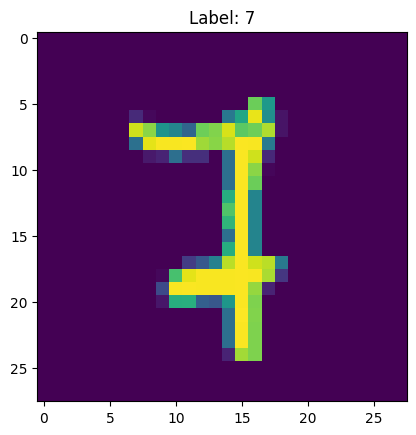

In [4]:
plt.figure()
plt.grid(False)

plt.imshow(np.reshape(original_image, (28,28)))
plt.title("Label: {}".format(np.argmax(original_label)))

plt.show()

### Now, we create the perturbation we will use to perform the attack

The execution of this attack consists on creating a small perturbation that we can add to a benign, normal image so as to make a machine learning model missclassify it but have it still look unaffected to the human eye.
>
Here we can see exactly what this looks like:

![Image](https://www.tensorflow.org/beta/tutorials/generative/images/adversarial_example.png)

[Fig 1. Visualisation of fgsm](https://www.tensorflow.org/beta/tutorials/generative/images/adversarial_example.png)

>

The way we create this perturbation is by calculating the gradient of the cost or loss function used by the model with respect to the image. The loss function is one that returns a value that describes how different the classification of a given image is from what it should be classified as. This gives us an indication of how to change each pixel in order to affect the value of the loss function the most. We then take the sign of these gradients as we are only interested in wether to increase or decrease each pixel, not by how much.

The formula for the perturbation is described by *I. Goodfellow et al* as:

$$\text{sign}(\nabla_xJ(\theta, x, y))$$

or as (they are both equal):

$$\text{sign}(\frac{\partial J(\theta, x, y)}{\partial x})$$

where:
* J : The loss function used by the model
* $\theta$ : The model parameters
* $x$ : The input image
* $y$ : the original label

>
This part of the tutorial was loosely adapted from [this guide](https://www.tensorflow.org/beta/tutorials/generative/adversarial_fgsm) made by the Tensorflow team.
>
The following function defines the implementation of this perturbation:

In [5]:
def create_perturbation(modelfn, input_image, original_label):
  loss_object = tf.keras.losses.CategoricalCrossentropy()

  # Reference the docs for GradientTape in tf2.0 for more info
  with tf.GradientTape() as gt:
    # Define the calculation that needs to be derived
    gt.watch(input_image)
    prediction = modelfn(input_image)
    # Update: fixing shape mismatch in updated version
    prediction = tf.reshape(prediction, [-1])
    ####
    loss = loss_object(original_label, prediction)

  # Get the gradients for the loss w.r.t image
  grads = gt.gradient(loss, input_image)
  perturbation = tf.sign(grads)

  return perturbation

We can now create the respective perturbation for the image we chose earlier and see what it looks like and what the model classifies it as.


1/1 [==============================] - 0s 82ms/step


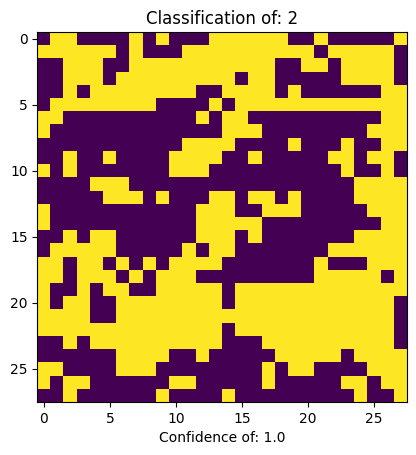

In [6]:
perturbation = create_perturbation(model, original_image, original_label)
perturbation_pred = model.predict(perturbation)

plt.figure()
plt.grid(False)
plt.imshow(np.reshape(perturbation,(28,28)))
plt.title("Classification of: {}".format(np.argmax(perturbation_pred)))
plt.xlabel("Confidence of: {}".format(np.max(perturbation_pred)))

plt.show()

### Finally, we implement the attack


To implement the attack we add the perturbation to the image, which we scale down by a value epsilon ($\epsilon$) to try to make it unperceivable. Although, depending on the model, the minimum for this value may differ.
>
By adding this perturbation to the image we change the pixels in the direction where the value of the loss function will increase or be maximised. An increase in the value of the loss function translates to the image being further away from being classified as the correct label.
>
The adversarial image or example is then the original image with the perturbation. It can be formalised as the following expression:
>
$$ \text{adv_example} = x + \epsilon * \text{sign}(\nabla_xJ(\theta, x, y)) $$
>
This next function implements the fgsm attack and creates the adversarial example:

In [7]:
def fgsm(modelfn, input_image, original_label, epsilon):
  perturbation = create_perturbation(modelfn, input_image, original_label)

  adv_example = input_image + (perturbation * epsilon)

  return adv_example

### Now, let's create the Adversarial Image


To do this we'll pass the original image we chose and it's correct label to the function we just defined to create its adversarial image. Then let's ask the model to predict what it thinks the image is, it should hopefully be different than what it looks like.

In [8]:
epsilon = 0.1

adv_image = fgsm(model, original_image, original_label, epsilon)
adv_image_pred = model.predict(adv_image)

1/1 [==============================] - 0s 17ms/step


Let's se what this looks like:

<ipython-input-19-d81567fdd680>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


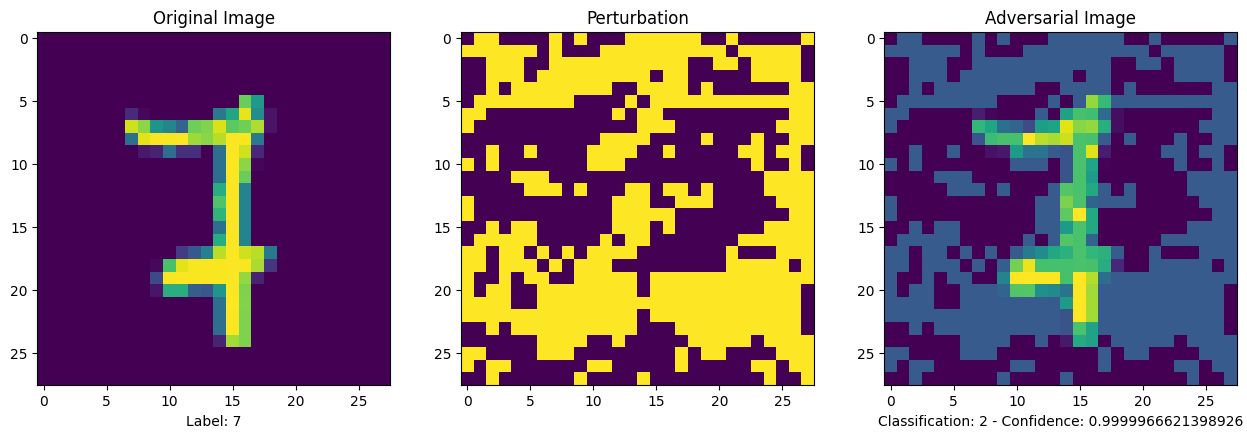

In [19]:
plt.figure()
plt.grid(False)

plt.subplot(1,3,1)
plt.subplots_adjust(right = 2)
plt.title("Original Image")
plt.imshow(np.reshape(original_image,(28,28)))
plt.xlabel("Label: {}".format(np.argmax(original_label)))

plt.subplot(1,3,2)
plt.subplots_adjust(right = 2)
plt.title("Perturbation")
plt.imshow(np.reshape(perturbation,(28,28)))


plt.subplot(1,3,3)
plt.subplots_adjust(right = 2)
plt.title("Adversarial Image")
plt.imshow(np.reshape(adv_image,(28,28)))
plt.xlabel("Classification: {} - Confidence: {}".format(np.argmax(adv_image_pred),np.max(adv_image_pred)))

plt.show()

Keep in mind that, as these are 28 * 28 images with pixel values ranging from 0 to 255, perturbations are easily seen and the perturbation required to missclassify the image might be visible. Something else to note is that some images may require bigger perturbations to be missclassified.

However, when this attack is applied identically to RGB images the perturbations are much more easily hidden and the attack is still effective. An example of this can be seen in [this guide](https://www.tensorflow.org/beta/tutorials/generative/adversarial_fgsm) provided by the Tensorflow team. I also encourage you to try to replicate this code with more complex datasets like CIFAR-10 or even ImageNet. You might also easily do this by just changing the code that trains the model and loads the data to something else keep the rest of the code the same.

> **Exercise 1:** For the same image sample, explore the range of possible values for epsilon, and report the lowest value that results in misclassification with a confidence of at least %95 (0.95).

In [48]:
#### Your Code
epsilon_list = [0.0000001,0.000005,0.00001,0.0001,0.0005,0.001,0.01,0.018,0.02,0.05,0.1, 0.2, 0.3, 0.4,1,10]  # Your list of epsilon values

for epsilon in epsilon_list:
  adv_image = fgsm(model, original_image, original_label, epsilon)
  adv_image_pred = model.predict(adv_image)

  # Print confidence and epsilon value
  print(f"Epsilon: {epsilon}, Confidence: {np.max(adv_image_pred):.4f}")


1/1 [==============================] - 0s 100ms/step
Epsilon: 1e-07, Confidence: 0.9275
1/1 [==============================] - 0s 63ms/step
Epsilon: 5e-06, Confidence: 0.9274
1/1 [==============================] - 0s 17ms/step
Epsilon: 1e-05, Confidence: 0.9273
1/1 [==============================] - 0s 17ms/step
Epsilon: 0.0001, Confidence: 0.9252
1/1 [==============================] - 0s 18ms/step
Epsilon: 0.0005, Confidence: 0.9150
1/1 [==============================] - 0s 16ms/step
Epsilon: 0.001, Confidence: 0.9005
1/1 [==============================] - 0s 17ms/step
Epsilon: 0.01, Confidence: 0.6840
1/1 [==============================] - 0s 19ms/step
Epsilon: 0.018, Confidence: 0.9562
1/1 [==============================] - 0s 17ms/step
Epsilon: 0.02, Confidence: 0.9699
1/1 [==============================] - 0s 28ms/step
Epsilon: 0.05, Confidence: 0.9992
1/1 [==============================] - 0s 30ms/step
Epsilon: 0.1, Confidence: 0.9999
1/1 [==============================] - 0s 25m

############# Your findings. ###############

accoridng to above experiment the epsilon should be between [0.01-0.2] and with 0.018 we reached 0.95 confidence Epsilon 0.05 resulted in a confidence of 99.92%, significantly above the 95% threshold.

### Targeted FGSM: A version of fgsm that can missclassify to a chosen desired label

What if we deliberately wanted to craft an image that was classified as something but that looked like something else? By changing a little of the logic behind the fgsm attack this exact thing can be achieved.
>
By instead of looking for what pixels to change to make the image be missclassified the most, let's look at what pixels to change to make the model be more confident about it being a certain class.

Technically, what we do is, again calculate the gradients of the loss with respect to the image but now the difference is that the loss is calculated with the target label like so.
>
$$\text{sign}(\nabla_xJ(\theta, x, y_{target}))$$
>
In this case, this creates a perturbation that tells us how to change each pixel to change how close or how away the image is from being the target label.
>
Therefore, we create our adversarial image by substracting the perturbation from the original image to try to decrease or minimize the value of the loss function, which means make the image be closer to being the target label. Formally the attack now looks like this:
>
$$ \text{targeted_adv_example} = x - \epsilon * \text{sign}(\nabla_xJ(\theta, x, y_{target})) $$
>
So, let's start by defining the function to create the targeted version of the attack.

In [36]:
def targeted_fgsm(modelfn, input_image, target_label, epsilon):
  perturbation = create_perturbation(modelfn, input_image, target_label)

  adv_example = input_image - (perturbation * epsilon)

  return adv_example

Great! Now we'll choose a random image to then craft into an adversarial example that will be classified as whatever we want.

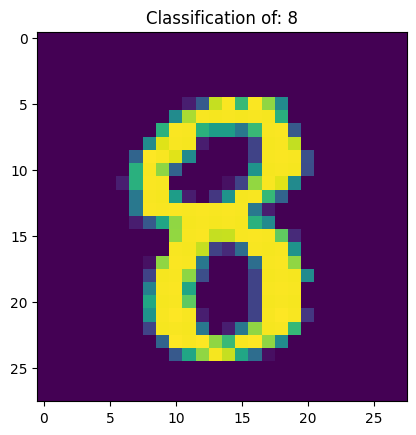

In [37]:
random_index = np.random.randint(train_images.shape[0])

untargeted_image = tf.convert_to_tensor(train_images[random_index].reshape((1,28,28)))
untargeted_image_label = train_labels[random_index]

plt.figure()
plt.grid(False)
plt.imshow(np.reshape(untargeted_image,(28,28)))
plt.title("Classification of: {}".format(np.max(untargeted_image_label)))

plt.show()

Effectively applying this targeted attack require a little more tinkering than the un-targeted version. Some images might be easier to craft into certain labels than into others and some might need a bigger epsilon than others. But, in general, this attack requires smaller epsilons to shift the images to be classified as the target label. This means that, in pracice, this type of attack is more effective as it not only allows you to manipulate the output of the model but also do it with adversarial images where their perturbation is more difficult to spot.
>
So, play around by changing the target label for the same image and tweak the value for epsilon and see what it's limits are. You might also want to rerun the previous cell to try different images.

If you then try to choose epsilons sufficently large it might go over the target label and classify it as something different, so, also try decreasing the value of epsilon.

1/1 [==============================] - 0s 17ms/step


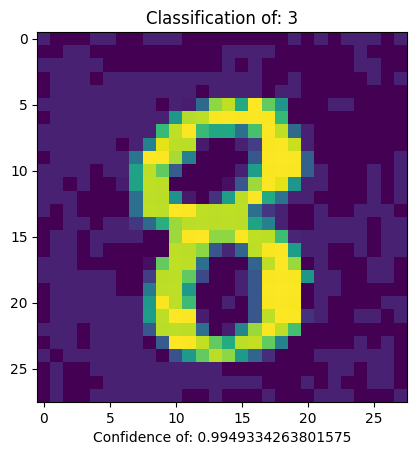

In [38]:
target = 3 # Change to something different than original and experiment changing it for the same image
epsilon = 0.05 # Change

target_label = tf.one_hot(target, num_classes) # This gives us the desired output of the model given our target, a one hot encoding for it

targeted_image = targeted_fgsm(model, untargeted_image, target_label, epsilon)

targeted_pred = model.predict(targeted_image)

plt.figure()
plt.grid(False)
plt.imshow(np.reshape(targeted_image,(28,28)))
plt.title("Classification of: {}".format(np.argmax(targeted_pred)))
plt.xlabel("Confidence of: {}".format(np.max(targeted_pred)))

plt.show()

> **Exercise 2:** For the same image sample, explore the range of possible values for epsilon, and report the lowest value that results in misclassification with a confidence of at least %95 (0.95). How does it compare with your results in Exercise 1? Include your interpretation of this comparison in your answer.

In [47]:
### Your Code ###
epsilon_list = [0.001, 0.00997,0.01,0.02, 0.05, 0.1, 0.2]  # Your list of epsilon values
target = 3  # Change to the desired target class

for epsilon in epsilon_list:
  target_label = tf.one_hot(target, num_classes)  # Create target label one-hot encoding

  targeted_image = targeted_fgsm(model, untargeted_image, target_label, epsilon)
  targeted_pred = model.predict(targeted_image)

  # Print confidence and epsilon value
  print(f"Epsilon: {epsilon}, Confidence: {np.max(targeted_pred):.4f}")

  # Remove plotting code


1/1 [==============================] - 0s 25ms/step
Epsilon: 0.001, Confidence: 0.9961
1/1 [==============================] - 0s 16ms/step
Epsilon: 0.00997, Confidence: 0.9584
1/1 [==============================] - 0s 17ms/step
Epsilon: 0.01, Confidence: 0.9580
1/1 [==============================] - 0s 26ms/step
Epsilon: 0.02, Confidence: 0.5935
1/1 [==============================] - 0s 19ms/step
Epsilon: 0.05, Confidence: 0.9949
1/1 [==============================] - 0s 18ms/step
Epsilon: 0.1, Confidence: 1.0000
1/1 [==============================] - 0s 17ms/step
Epsilon: 0.2, Confidence: 0.9996


########## Your Answer ##########

Epsilon 0.01 achieved a confidence of 95.80%, reaching the desired threshold for targeted misclassification.

## Where to find more information:
If you would like to learn more about and implement different types of attacks and defenses that have been developed against them or an integrated way to do adversarial training check out the Adversarial Machine Learning library [CleverHans](https://github.com/tensorflow/cleverhans) mantained by I. Goodfellow, the author of the paper proposing the fgsm attack, and N. Papernot. It offers an easy way to implement these attacks and research on the extent of their applications without having to write the type code described in this notebook yourself.